# EDSA - Climate Change Belief Analysis 2021
### Team TS5 Classification

<div align="center" style="width: 1000px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/CPNMorgan/Team_TS5_JHB_Classification/main/climat change.jpg"
     alt="Titanic"
     style="float: center; padding-bottom=0.5em"
     width=1000px/>

</div>

# Challange Description

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

# Introduction

# Importing Packages

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#from plotly import graph_objs as go
import seaborn as sns
from plotly import graph_objs as go

#nlp
import string
import re    #for regex
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.tokenize import TweetTokenizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union
from wordcloud import WordCloud 
from collections import Counter

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [29]:
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')

## First look into data

In [30]:
# Merging both the data sets
concat_df = train_df.append(test_df, 
                             ignore_index=True,
                             sort=False)
concat_df.head(3)

,sentiment,message,tweetid
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1.0,It's not like we lack evidence of anthropogeni...,126103
2,2.0,RT @RawStory: Researchers say we have three ye...,698562


In [31]:
len(concat_df)

26365

In [32]:
#check the shape of the data
train_df.shape, test_df.shape

((15819, 3), (10546, 2))

In [33]:
#unique sentiments
train_df['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [34]:
train_df['sentiment'].describe()

count    15819.000000
mean         0.917504
std          0.836537
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: sentiment, dtype: float64

In [35]:
#check for nulls
train_df.isnull().sum(), test_df.isnull().sum()

(sentiment    0
 message      0
 tweetid      0
 dtype: int64,
 message    0
 tweetid    0
 dtype: int64)

In [36]:
test_df.isnull().sum()

message    0
tweetid    0
dtype: int64

In [37]:
concat_df['sentiment'].describe()

count    15819.000000
mean         0.917504
std          0.836537
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: sentiment, dtype: float64

In [38]:
#describe the data
print(concat_df['sentiment'].unique())

[ 1.  2.  0. -1. nan]


In [39]:
concat_df.isnull()

,sentiment,message,tweetid
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
26360,True,False,False
26361,True,False,False
26362,True,False,False
26363,True,False,False


## Data cleaning:
- The EDA text cleaning function executes the following steps:
  - lowercase all words
  - Remove noise such as punctuation and URLs  
  

In [40]:
# function that takes a tweet message and a character e.g @ and remove the character from the sentence
# Returns the sentence without the character
# Define the function to remove the punctuation
def remove_punctuations(msg):
    msg = str(msg).lower()
    msg = re.sub('\[.*?\]', '', msg)
    msg = re.sub('https?://\S+|www\.\S+', '', msg)
    msg = re.sub('<.*?>+', '', msg)
    msg = re.sub('[%s]' % re.escape(string.punctuation), '', msg)
    msg = re.sub('\n', '', msg)
    msg = re.sub('\w*\d\w*', '', msg)
    msg = re.sub('rt','',msg)
    return msg


In [41]:
train_df['clean_message'] = train_df['message'].apply(lambda x:remove_punctuations(x))
test_df['clean_message'] = test_df['message'].apply(lambda x:remove_punctuations(x))
test_df.head()

,message,tweetid,clean_message
0,Europe will now be looking to China to make su...,169760,europe will now be looking to china to make su...
1,Combine this with the polling of staffers re c...,35326,combine this with the polling of staffers re c...
2,"The scary, unimpeachable evidence that climate...",224985,the scary unimpeachable evidence that climate ...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin got ...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,fakewillmoore female orgasms cause global war...


### Removing Stop Words

In [42]:
train_df['clean_message'] = train_df['clean_message'].apply(lambda x: ' '.join([a for a in x.split() if len(a)>3]))
test_df['clean_message'] = test_df['clean_message'].apply(lambda x: ' '.join([a for a in x.split() if len(a)>3]))

In [43]:
test_df.head()

,message,tweetid,clean_message
0,Europe will now be looking to China to make su...,169760,europe will looking china make sure that alone...
1,Combine this with the polling of staffers re c...,35326,combine this with polling staffers climate cha...
2,"The scary, unimpeachable evidence that climate...",224985,scary unimpeachable evidence that climate chan...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin jill...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,fakewillmoore female orgasms cause global warm...


## Exploratory Data Analysis (EDA)

 Exploratory Data Analysis (EDA) refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations

In [44]:
#copy_df = train_df.copy()
# Labeling the target
train_df['sentiment'] = [['Negative(-1)', 'Neutral(0)', 'Positive(1)', 'News(2)'][x+1] for x in train_df['sentiment']]

#### Discreption of Sentiments:
- 2 News: the tweet links to factual news about climate change
- 1 Positive: the tweet supports the belief of man-made climate change
- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
- -1 Negative: the tweet does not believe in man-made climate change

In [45]:
dist = train_df.groupby('sentiment').count()['clean_message'].reset_index().sort_values(by='clean_message',ascending=True)
dist.style.background_gradient(cmap='Greens')

,sentiment,clean_message
0,Negative(-1),1296
1,Neutral(0),2353
2,News(2),3640
3,Positive(1),8530


#### Count of words per sentiment

<AxesSubplot:xlabel='sentiment', ylabel='count'>

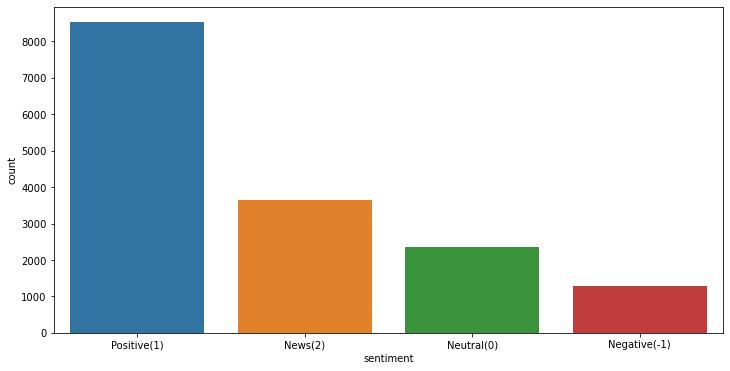

In [46]:
labels = []
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train_df)

### Observations
- The graph a bove shows that the words in the positive sentiment are higher compare to others, with 8000 words, were by the rest are below 4000

## Funnel chart to get more insight from sentiments

In [47]:
fig = go.Figure(go.Funnelarea(
    text =train_df.sentiment,
    values = dist.clean_message,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()


### Observation
- Negative(-1) Sentiment shows the less of counted words with the percentage of 8.19
- Neutral(0) shows 14.9 percents of counted words
- News(2) shows 23 percents of counted words
- And Positive comments shows the highest percentage of 53.9 of counted words

## checking average length of each sentiment catergory

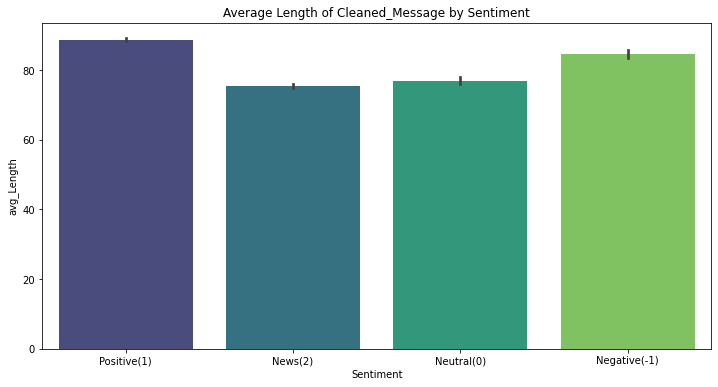

In [48]:
plt.figure(figsize=(12,6))
sns.barplot(x='sentiment', y=train_df['clean_message'].apply(len) ,data = train_df, palette='viridis')
plt.ylabel('avg_Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Cleaned_Message by Sentiment')
plt.show()

### Observations:
 -

In [49]:
tweetid = train_df['tweetid']
#df_test = df_test.drop('Index', axis = 1)

len(tweetid)

15819

## Most Common words in our Target-Selected Message

In [50]:
train_df['new_lis'] = train_df['clean_message'].apply(lambda x:str(x).split())
words = Counter([item for sublist in train_df['new_lis'] for item in sublist])
new = pd.DataFrame(words.most_common(10))
new.columns = ['Common_words','count']
new.style.background_gradient(cmap='Reds')

,Common_words,count
0,climate,12863
1,change,12087
2,global,3758
3,warming,3359
4,trump,1917
5,about,1802
6,that,1525
7,believe,1153
8,this,1087
9,have,991


In [51]:
import plotly.express as px
fig = px.bar(new, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=600, height=600,color='Common_words')
fig.show()

### Observations:
 -

## Most common words Sentiments Wise

In [52]:
Positive = train_df[train_df['sentiment']=='Positive(1)']
Negative = train_df[train_df['sentiment']=='Negative(-1)']
Neutral = train_df[train_df['sentiment']=='Neutral(0)']
News = train_df[train_df['sentiment']=='News(2)']


### Most common positive(1) words

In [53]:
#MosT common positive words
top = Counter([item for sublist in Positive['new_lis'] for item in sublist])
positive_w = pd.DataFrame(top.most_common(10))
positive_w.columns = ['Common_words','count']
positive_w.style.background_gradient(cmap='Greens')

,Common_words,count
0,climate,7328
1,change,6898
2,global,1590
3,warming,1396
4,about,1150
5,believe,1000
6,that,946
7,trump,883
8,this,729
9,doesnt,717


In [54]:
fig = px.bar(positive_w, x="count", y="Common_words", title='Most Commmon Positive(1) Words', orientation='h', 
             width=600, height=600,color='Common_words')
fig.show()

### Observations:
 -

### Most common negative words

In [55]:

top = Counter([item for sublist in Negative['new_lis'] for item in sublist])
negative = pd.DataFrame(top.most_common(10))
negative = negative.iloc[1:,:]
negative.columns = ['Common_words','count']
negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,change,721
2,global,632
3,warming,589
4,about,166
5,that,158
6,this,107
7,have,79
8,with,79
9,science,75


In [56]:
fig = px.bar(negative, x="count", y="Common_words", title='Most Commmon Negative(-1) Words', orientation='h', 
             width=600, height=600,color='Common_words')
fig.show()

### Observation:
 -

### Most common neutral(0) words

In [57]:
top = Counter([item for sublist in Neutral['new_lis'] for item in sublist])
neutral = pd.DataFrame(top.most_common(10))
neutral = neutral.iloc[1:,:]
neutral.columns = ['Common_words','count']
neutral.style.background_gradient(cmap='Blues')

,Common_words,count
1,change,1343
2,global,1033
3,warming,949
4,about,324
5,that,261
6,this,217
7,with,178
8,what,157
9,trump,150


In [58]:
fig = px.bar(neutral, x="count", y="Common_words", title='Most Commmon Neutral(0) Words', orientation='h', 
             width=600, height=600,color='Common_words')
fig.show()

### Observation:
 -

### Most common news(2) words

In [59]:
top = Counter([item for sublist in News['new_lis'] for item in sublist])
news = pd.DataFrame(top.most_common(10))
news = news.iloc[1:,:]
news.columns = ['Common_words','count']
news.style.background_gradient(cmap='Reds')

,Common_words,count
1,change,3125
2,trump,827
3,global,503
4,warming,425
5,from,252
6,says,240
7,with,188
8,scientists,178
9,over,171


In [60]:
fig = px.bar(news, x="count", y="Common_words", title='Most Commmon Neutral(0) Words', orientation='h', 
             width=600, height=600,color='Common_words')
fig.show()

### Observation:
 -

### Counting number of Emojis used in the texts

In [61]:
import emoji
emojis_df=[]
for string in test_df['clean_message']:
    my_str = str(string)
    for each in my_str:
        if each in emoji.UNICODE_EMOJI['en'].keys():
            emojis_df.append(each)
freq = (Counter(i for sub in emojis_df for i in set(sub))) 
sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)

In [62]:
print(sort_orders)

[('😂', 11), ('™', 9), ('😍', 7), ('🏽', 7), ('👇', 6), ('❄', 5), ('♥', 5), ('❓', 5), ('🏻', 3), ('▶', 3), ('⬆', 3), ('😊', 3), ('❌', 3), ('😫', 3), ('♂', 3), ('©', 2), ('➡', 2), ('💯', 2), ('☁', 2), ('🔥', 2), ('😁', 2), ('🤷', 1), ('♀', 1), ('🐼', 1), ('🐻', 1), ('🐝', 1), ('🐠', 1), ('🐚', 1), ('🌷', 1), ('🍀', 1), ('🌎', 1), ('☎', 1), ('🎉', 1), ('🤔', 1), ('⚡', 1), ('👀', 1), ('👊', 1), ('🖕', 1), ('👌', 1), ('😟', 1), ('💩', 1), ('⚖', 1), ('☀', 1), ('🤦', 1), ('🏼', 1), ('🐸', 1), ('☕', 1), ('🔀', 1), ('‼', 1), ('😳', 1), ('🙈', 1), ('😉', 1)]


### Observation:
- The most common emoji is the 'face with tears of joy' is an emoji featuring a jovial face laughing, while also crying out tears
- We have other emjis that illustrate the impacts of global warmaing on weather and climate change, e.g 'earth,fire,flowers and snowflake'

### WordCloud of most common positive words used.


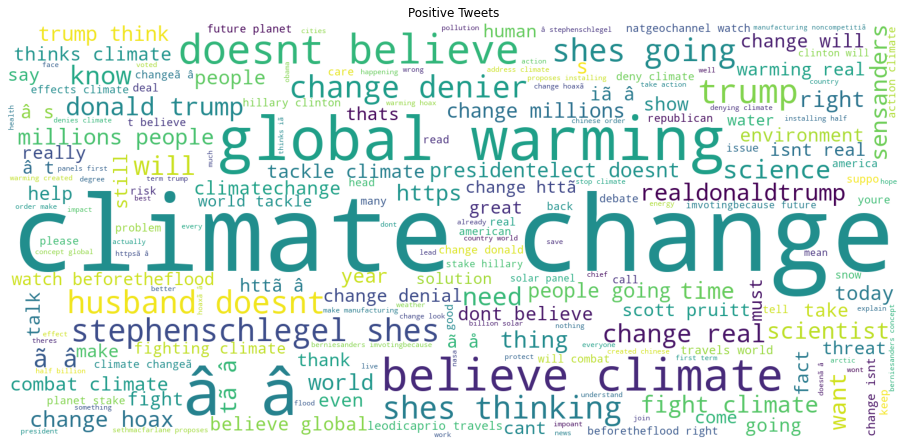

In [80]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Positive[Positive['sentiment'] == 'Positive(1)']
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Positive Tweets')
plt.axis("off")
plt.show()

### Observations:
 -

### WordCloud of most common negative words used

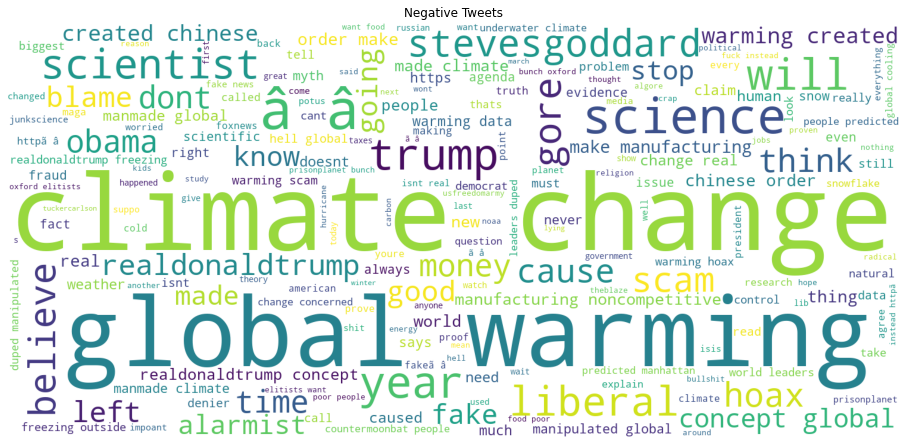

In [79]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Negative[Negative['sentiment'] == 'Negative(-1)']
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Negative Tweets')
plt.axis("off")
plt.show()

### Observations:
 -

### WordCloud of most common neutral words used

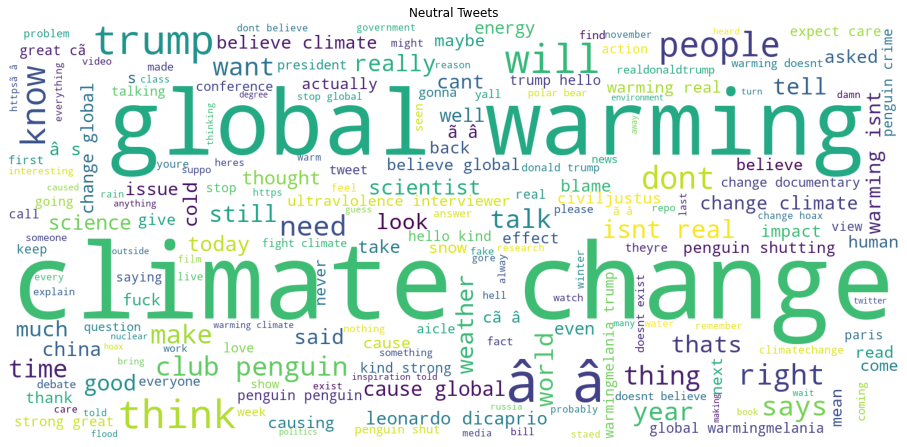

In [78]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Neutral[Neutral['sentiment'] == 'Neutral(0)']
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Neutral Tweets')
plt.axis("off")
plt.show()

### Observations:
 -

### WordCloud of most common neutral words used

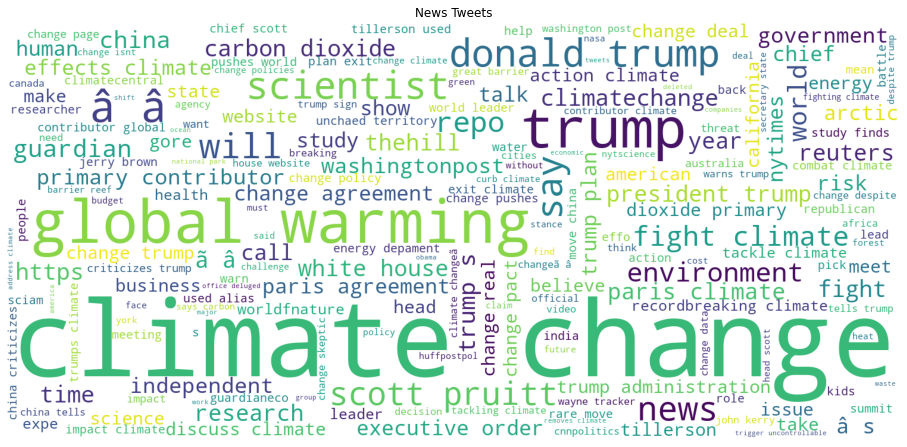

In [77]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(News[News['sentiment'] == 'News(2)']
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('News Tweets')
plt.axis("off")
plt.show()

### WordCloud of most common words used 'Overall'
- Wordcloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance

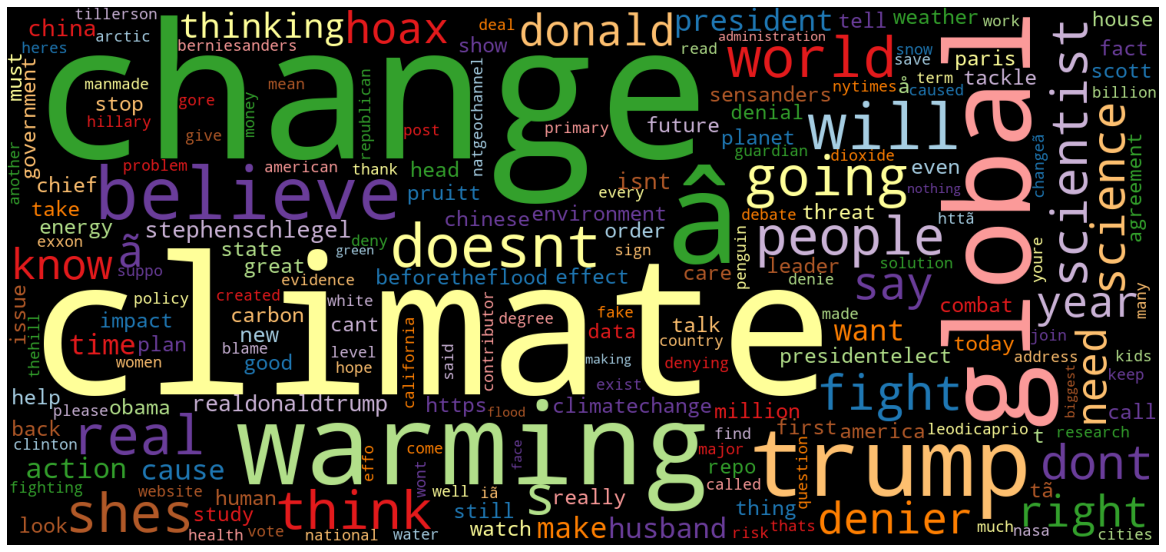

In [63]:
train_msg = " ".join(tweet for tweet in train_df.clean_message)
train_wordcloud = WordCloud(max_font_size=250,
                            background_color="black",
                            width=1500,
                            height=700,
                            collocations=False,
                            colormap='Paired').generate(train_msg)
plt.figure(figsize=(16, 10))
plt.imshow(train_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Observation:
 - 

## Data Preprosessing

In [244]:
train = train_df['clean_message']

vectorizer = CountVectorizer()
count_vectorized = vectorizer.fit_transform(train)

In [245]:
concat_data = train_df.append(test_df, ignore_index=True)

In [246]:
"""
Setting the parameters for the Vectorizer

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )

"""

"\nSetting the parameters for the Vectorizer\n\nvectorizer = CountVectorizer(analyzer = 'word', \n                             tokenizer = None, \n                             preprocessor = None, \n                             stop_words = None, \n                             max_features = 180000,\n                             min_df = 1,\n                             ngram_range = (1,2)\n                            )\n\n"

In [27]:
##########################################################################################
# Building a Pipeline for word vectorization
pipe = Pipeline( [('vect', vectorizer)] )
# Fitting & transforming the data
train_vect = pipe.fit_transform(train_df['clean_message'])
test_vect = pipe.transform(test_df['message'])## we forgot to transform our test data 

"""
We have to analyse our test data aswell



# Inspecting the shape of our vectorized data
print('train dim:', train_vect.shape, 'test dim:', test_vect.shape)

"""


##############################################################################################

"\nWe have to analyse our test data aswell\n\n\n\n# Inspecting the shape of our vectorized data\nprint('train dim:', train_vect.shape, 'test dim:', test_vect.shape)\n\n"

In [28]:
# Converting the collection of clean messages to a matrix of TF-IDF features
data = train_df['clean_message']

#vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
#vectorized = vectorizer.fit_transform(data)




In [29]:
"""
import scipy.sparse

# Defining the features as well as the label
X = scipy.sparse.hstack([vectorized, count_vectorized])
y = train_df['sentiment']




# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    shuffle=False)


"""



"\nimport scipy.sparse\n\n# Defining the features as well as the label\nX = scipy.sparse.hstack([vectorized, count_vectorized])\ny = train_df['sentiment']\n\n\n\n\n# Train/Test split\nX_train, X_test, y_train, y_test = train_test_split(X,\n                                                    y,\n                                                    test_size=0.20,\n                                                    shuffle=False)\n\n\n"

In [30]:
from sklearn.model_selection import train_test_split

# Splitting the previously defined features and label of your dataset
X_train, X_test, y_train, y_test = train_test_split(train_vect, train_df['sentiment'],
                                                    test_size = 0.3,
                                                    random_state=42,stratify=train_df['sentiment'])

In [31]:
# Here 'ovr' indicates that we have selected our One-vs-Rest strategy. 
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train, y_train)
# Generate predictions
#y_pred_test = logreg.predict(X_test)#####WE NEED TEST VECTOR as parameter
y_pred_test = logreg.predict(test_vect)

#'tweetid': test_df['tweetid']

/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

In [33]:
Logistic = pd.DataFrame(data={'tweetid': test_df['tweetid'],'sentiment': y_pred_test})

In [34]:
Logistic.to_csv("Team_TS5_Regression2.csv", index=False)

In [35]:
## WE JUST TRAINED OUR MODEL BASED ON LOGISTIC 

In [36]:
# Creating a list of all the models to train
algs = [LogisticRegression(random_state = 5), SVC(kernel = 'linear', random_state = 5), SVC(kernel = 'rbf', random_state = 5)
        ,MultinomialNB(), KNeighborsClassifier(), DecisionTreeClassifier(max_depth=6),RandomForestClassifier()]

In [37]:
# Fitting models onto the training data and predicting.
for i in range(0, len(algs)):
    text_clf = Pipeline([('clf', algs[i])])
    text_clf.fit(X_train, y_train)  
    predictions = text_clf.predict(X_test)
    
    
    print(algs[i])
    print(metrics.confusion_matrix(y_test,predictions))
    print(metrics.classification_report(y_test,predictions))
    print('F1_score: ',round(metrics.f1_score(y_test,predictions, average = 'weighted'),3))
    print('-------------------------------------------------------')

/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression(random_state=5)
[[ 155   51  159   24]
 [  32  277  327   70]
 [  35  107 2188  229]
 [   6   33  257  796]]
              precision    recall  f1-score   support

          -1       0.68      0.40      0.50       389
           0       0.59      0.39      0.47       706
           1       0.75      0.86      0.80      2559
           2       0.71      0.73      0.72      1092

    accuracy                           0.72      4746
   macro avg       0.68      0.59      0.6

In [ ]:
"""

# Here 'ovr' indicates that we have selected our One-vs-Rest strategy. 
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train, y_train)
# Generate predictions
y_pred_test = logreg.predict(X_test)

Logistic = pd.DataFrame({'tweetid': tweetid,'sentiment': y_pred_test})
Logistic.to_csv("Team_TS5_Regression.csv", index=False)

## References
- Websites used for insipiration

- analyticsvidhya: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
- towardsdatascience: https://towardsdatascience.com/how-to-efficiently-remove-punctuations-from-a-string-899ad4a059fb
- codegrepper:  https://www.codegrepper.com/code-examples/python/pandas+series+remove+punctuation